In [1]:
# Useful numeric packages:
import numpy as np

# File utilities:
import os.path

# Data warehousing:
import pandas as pd

# Data visualisation:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns
plt.style.use('seaborn-muted')

In [2]:
dateparse = lambda x: pd.to_datetime(x, format = '%Y%m%d%H%M%S', errors = 'coerce')

d = pd.read_csv('events_log.csv.gz',
                compression = 'gzip', # To read .gz files
                dtype = {'timestamp': 'str'}, # To force timestamp to be read as a string, not a number
                parse_dates = ['timestamp'], # To convert timestamp into a date
                date_parser = dateparse) # To use a custom date parser for timestamp

# Mark column "action" as categorical and give the categories.
# We also give an ordering of the categories because if there is an error in the
# data and multiple pages appear with the same timestamp (e.g., the user lost
# connection and, when reconnected, all their "pings" arrived at once) then this
# can help re-establishing a plausible order: first searched, then visited the page,
# then replied to the pings.
d.action = pd.Categorical(d.action, categories = ['searchResultPage', 'visitPage', 'checkin'], ordered = True)

# Sort the value per session id; whithin each session, by timestamp; if
# there are multiple entries with the same timestamp, by category.
# Reset the index to renumber the rows according to the new sorting
d = d.sort_values(['session_id', 'timestamp', 'action']).reset_index()

### Observations on the input data

#### 1. Wrong `timestamp` values

In the input file, some `timestamp` values are invalid becase they were printed as the corresponding floating point numbers. For example, take the following row:
    deac7c11f00d598292f9e18ee2f6997f,2.0160304e+13,426b242692d66473,a,searchResultPage,NA,2ab3d9ca41b16173,20,NA

Here the timestamp is `2.0160304e+13`.
In this case, I still keep the row, but put the special `NaT` (Not a Time) value as the timestamp.
Note that I could still recover the date without the time.
For example, the above timestamp would correspond to 2016/03/04, but then I should put some fake placeholder for hours, minutes, and seconds.
But then I will not be able to distinguish complete timestamp from these 'artificial' ones.
Therefore, I just opt for marking the whole field as `NaT`.

#### 2. Missing `result_position` values

There are rows corresponding to a visit ot a search result, for which the corresponding `result_position` value is missing. For example:

In [3]:
d[(d.action == 'visitPage') & (d.result_position.isnull())].head()

,index,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position
51,174566,6fc560870efc555483fd3f3a44fc0cc3,2016-03-03 16:57:04,0007b7f6b575feb6,a,visitPage,NaN,cd0830379a43b008,NaN,NaN
52,29978,134b0ab20d805a3ca73bda1344ee31e6,2016-03-03 16:57:06,0007b7f6b575feb6,a,visitPage,NaN,2cfc3647b762a0e6,NaN,NaN
240,336599,d71b7bf35b8354428634c949d58ebcec,2016-03-01 06:55:22,0024c4506bf92e1c,a,visitPage,NaN,ffd856e8e1e4bea8,NaN,NaN
329,320168,cc9eb1d0a24957f9a7a75d1a112f05dc,2016-03-02 07:17:37,00317ffe60c93021,a,visitPage,NaN,edc17d5f9a082e37,NaN,NaN
333,340455,d99dfaa7c513567f8ab3e8c7e4376ef3,2016-03-02 07:18:09,00317ffe60c93021,a,visitPage,NaN,3ed5e3ae70472ad0,NaN,NaN


We assume that these correspond to pages visited without first seaching for them.
For example, links followed from page to page, or from an external website.

#### 3. Missing or simultaneous pings

Sometimes some pings (checkin `action`s) are missing, or more than one was recorded at the same time.
See, for example:

In [4]:
d[d.session_id == '0fabaa14450664df']

,index,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position
24838,73174,2ef7f927a4d25442a14c8b3ca54f6509,2016-03-05 21:25:51,0fabaa14450664df,a,searchResultPage,NaN,3228ee0e2e341939,17.0,NaN
24839,162614,6840526e26da58b892247310ed7f2baa,2016-03-05 21:25:55,0fabaa14450664df,a,searchResultPage,NaN,cb062420b8de3c87,20.0,NaN
24840,285580,b66b04a9c595530b839b8d1b08aa0219,2016-03-05 21:26:21,0fabaa14450664df,a,visitPage,NaN,402dfd801d9baf7b,NaN,1.0
24841,217169,8acb67d894985ca99f3fce70e0940c05,2016-03-05 21:26:21,0fabaa14450664df,a,checkin,20.0,402dfd801d9baf7b,NaN,1.0
24842,283596,b52a4b7bdce755099c9422a6c91d1199,2016-03-05 21:26:21,0fabaa14450664df,a,checkin,10.0,402dfd801d9baf7b,NaN,1.0
24843,382270,f4794e25188e5c2f9df4e64b687470c6,2016-03-05 21:26:31,0fabaa14450664df,a,checkin,30.0,402dfd801d9baf7b,NaN,1.0
24844,261534,a70365c4a3a35d68afd1040dbc376966,2016-03-05 21:26:41,0fabaa14450664df,a,checkin,40.0,402dfd801d9baf7b,NaN,1.0
24845,113945,4915751a1c5e565a8342a5d9fe1b6e0f,2016-03-05 21:26:51,0fabaa14450664df,a,checkin,50.0,402dfd801d9baf7b,NaN,1.0
24846,171308,6dae7779b94555ddb0d2031cf7c36987,2016-03-05 21:27:01,0fabaa14450664df,a,checkin,60.0,402dfd801d9baf7b,NaN,1.0
24847,357358,e48a348197db5900b66645f44afbffb7,2016-03-05 21:27:31,0fabaa14450664df,a,checkin,90.0,402dfd801d9baf7b,NaN,1.0


Here the page visit and the first 2 pings happen at the same time; furthermore there are no pings for times 70, 80, 100, and 110.

#### 4. Relational structure

The data has a relational structure.
For example, each visitPage has to refer to one specific searchResultPage the user was coming from.
Or each checkin relates to the corresponding page the user was visiting.
Some column only make sense for certain types of pages; e.g., `n_results` only makes sense for searchResultPage and `result_position` only makes sense for visitPage.
This suggests that a single csv file might not be the best way of doing data warehousing for this dataset and that, for more complex analysis and in the long term, the data could be stored in a relational database.

For example, we could have a *sessions* table, containing the session id and the user's group (A or B).
A *search results* table containing info about search results pages and linked to the corresponding session.
Finally, a *visited pages* table contaning info about visited results and linked to the corresponding search result page (if any).
Note that we don't need to explicitly model pings ('checkin' actions) as we might just look at the last ping related to each visited page and store the corresponding time the user spent on the page directly in the *visited pages* table.

### 1. What is the daily overall clickthrough rate? How does it vary between the groups?

The clickthrough rate was defined as *"the proportion of search sessions where the user clicked on one of the results displayed"*.
Therefore we can compute it as the ratio between the number of sessions that contain at least one page visit coming from a search (`result_position` not null), and the number of sessions that contain a search results page with at least one result (`n_results` not zero).

In [5]:
# Add a column to only keep track of the date
d['date'] = d.timestamp.dt.date

In [6]:
# Get all the sessions with at least one visitPage coming from a search
click_sessions = d[(d.action == 'visitPage') & ~(d.result_position.isnull())].groupby(['session_id'])

# Get all the sessions with a search results page with at least one result
results_sessions = d[(d.action == 'searchResultPage') & (d.n_results > 0)].groupby(['session_id'])

In [7]:
# Take just one row for each group (the first one)
# Group by date and user group
# Count how many rows in each group
# Sort by ascending date and user group
click_by_date = click_sessions.first()                          \
                              .groupby(['date', 'group'])       \
                              .count()                          \
                              .sort_values(['date', 'group'])

In [8]:
# We use the count() of column 'uuid' as the number of sessions with clicks
click_by_date = click_by_date.rename(columns = {'uuid': 'clicks'})
# We get rid of all other count()'s for columns we don't need
click_by_date = click_by_date[['clicks']]

In [9]:
click_by_date

clicks
date       group        
2016-03-01 a        2825
           b         697
2016-03-02 a        2874
           b         725
2016-03-03 a        2841
           b         781
2016-03-04 a        2372
           b         913
2016-03-05 a        1763
           b         809
2016-03-06 a        2111
           b         854
2016-03-07 a        2645
           b        1099
2016-03-08 a        2274
           b         865

In [10]:
# Take just one row for each group (the first one)
# Group by date and user group
# Count how many rows in each group
# Sort by ascending date and user group
results_by_date = results_sessions.first()                        \
                                  .groupby(['date', 'group'])     \
                                  .count()                        \
                                  .sort_values(['date', 'group'])

In [11]:
# We use the count() of column 'uuid' as the number of sessions with non-empty search result pages
results_by_date = results_by_date.rename(columns = {'uuid': 'search_result_pages'})
# We get rid of all other count()'s for columns we don't need
results_by_date = results_by_date[['search_result_pages']]

In [12]:
results_by_date

search_result_pages
date       group                     
2016-03-01 a                     3984
           b                     4176
2016-03-02 a                     4013
           b                     4132
2016-03-03 a                     4006
           b                     4280
2016-03-04 a                     3350
           b                     3982
2016-03-05 a                     2581
           b                     3275
2016-03-06 a                     2966
           b                     3713
2016-03-07 a                     3821
           b                     4620
2016-03-08 a                     3245
           b                     3861

In [13]:
# Create a unique table to compute the clickthrough rate
ctr = results_by_date.join(click_by_date)

In [14]:
ctr

search_result_pages  clicks
date       group                             
2016-03-01 a                     3984    2825
           b                     4176     697
2016-03-02 a                     4013    2874
           b                     4132     725
2016-03-03 a                     4006    2841
           b                     4280     781
2016-03-04 a                     3350    2372
           b                     3982     913
2016-03-05 a                     2581    1763
           b                     3275     809
2016-03-06 a                     2966    2111
           b                     3713     854
2016-03-07 a                     3821    2645
           b                     4620    1099
2016-03-08 a                     3245    2274
           b                     3861     865

In [15]:
# First we only consider the daily clickthrough, for both groups
# We use reset_index to still have 'date' as a normal column
# and be able to use it to plot.
ctr_by_date = ctr.groupby(['date']).sum().reset_index()

# Compute the clickthrough as the ratio between sessions with visits
# and sessions with non-empty search results
ctr_by_date['clickthrough'] = ctr_by_date.clicks / ctr_by_date.search_result_pages

In [16]:
ctr_by_date

,date,search_result_pages,clicks,clickthrough
0,2016-03-01,8160,3522,0.431618
1,2016-03-02,8145,3599,0.441866
2,2016-03-03,8286,3622,0.437123
3,2016-03-04,7332,3285,0.448036
4,2016-03-05,5856,2572,0.439208
5,2016-03-06,6679,2965,0.443929
6,2016-03-07,8441,3744,0.443549
7,2016-03-08,7106,3139,0.441739


I can now plot the daily clickthrough rate for all users.
Note that, to better appreciate the different heights of each bar, the y-axis does not start from 0.

/usr/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


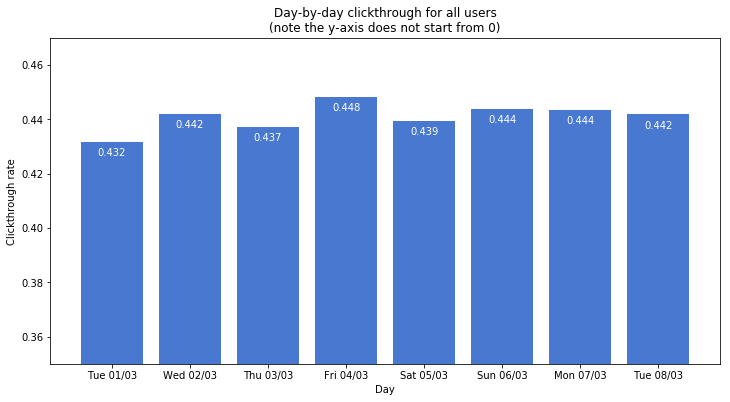

In [17]:
# To format dates on the x-axis
fmt = mdates.DateFormatter('%a %d/%m')

fig, ax = plt.subplots(figsize = (12, 6))
ax.bar(ctr_by_date.date, ctr_by_date.clickthrough)
ax.set_title('Day-by-day clickthrough for all users\n(note the y-axis does not start from 0)')
ax.set_xlabel('Day')
ax.set_ylabel('Clickthrough rate')
ax.set_ylim(0.35, 0.47)
ax.xaxis.set_major_formatter(fmt)

# To write the numeric value for each bar
for i, row in ctr_by_date.iterrows():
    ax.text(row.date, row.clickthrough - 0.005, "{:.3f}".format(row.clickthrough), color = 'white', horizontalalignment = 'center')

In [18]:
# Create two utility dataframes, to aid plotting
# One for users of Group A, and one for those of Group B
c = ctr.reset_index()
c['clickthrough'] = c.clicks / c.search_result_pages
ca = c[c.group == 'a']
cb = c[c.group == 'b']

I can now plot the daily data, decomposed for users of test groups A and B.

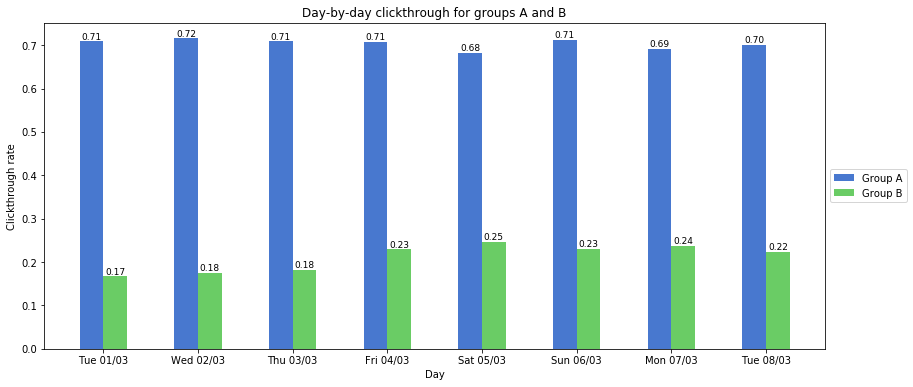

In [19]:
# Width of each bar
barw = .5

fig, ax = plt.subplots(figsize = (14, 6))
ax.bar(ca.index, ca.clickthrough, label = 'Group A', width = barw)
ax.bar(cb.index - barw, cb.clickthrough, label = 'Group B', width = barw)
ax.set_title('Day-by-day clickthrough for groups A and B')
ax.set_xlabel('Day')
ax.set_ylabel('Clickthrough rate')

# Place the x-axis ticks between left and right bar
ax.set_xticks(ca.index + barw/2)

# Write the date as label for each x-axis tick
xlabels = pd.to_datetime(ca.date).dt.strftime('%a %d/%m')
ax.set_xticklabels(xlabels)

# Place the legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Write the numeric value above each bar
for i, row in ca.iterrows():
    ax.text(i, row.clickthrough + 0.005, "{:.2f}".format(row.clickthrough), horizontalalignment = 'center', fontsize = 9)
for i, row in cb.iterrows():
    ax.text(i - barw, row.clickthrough + 0.005, "{:.2f}".format(row.clickthrough), horizontalalignment = 'center', fontsize = 9)

In [20]:
# Count how many users belong to groups A and B, to make
# sure that the data is not heavily unbalanced
d_a = d[d.group == 'a'].groupby(['session_id'])
d_b = d[d.group == 'b'].groupby(['session_id'])

In [21]:
print("There are {} sessions for A users and {} sessions for B users".format(len(d_a), len(d_b)))

There are 29427 sessions for A users and 38601 sessions for B users


In [60]:
# Calculate the overall clickthrough rates per user group (over all days)
ctr_group = ctr.reset_index().groupby('group').mean()
ctr_group['clickthrough'] = ctr_group.clicks / ctr_group.search_result_pages

In [61]:
ctr_group

,search_result_pages,clicks,clickthrough
group,,,
a,3495.750,2463.125,0.704606
b,4004.875,842.875,0.210462


#### Answer
* The daily overall clickthrough rate is quite stable, always in between 0.43 and 0.45.
* There is, however, a great variation between users of Group A and Group B.
* A users are much more likely than B users to click on a link during their sessions.
* The clickthrough rate for A users never falls below 0.68; the one for B users never raises above 0.25.

*Possible improvements*:
* In a single session a user could have made multiple searches. Some of them could have produced page visits, and some not. Depending on the application, it might make sense to compute the clickthrough rate for each search result page, rather than for each session.
* For some search results page, the user could have opened multiple results (e.g., in different browser tabs). We should decide if these all count towards increasing the clickthrough, or if multiple opened page just count as one.
* When providing day-by-day results, we should take into account that a little imprecision can be introduced by searches that have occurred shortly before midnight, but whose corresponding result was clicked shortly ater midnight. In this case the search is counted for the clickthrough of one day, and the click for the clickthrough of the next day. A relational database which associates clicks to searches would solve this problem (and we could, e.g., count both events towards the clickthrough of the day when the search results page was displayed).

### 2. Which results do people tend to try first? How does it change day-to-day?

In [22]:
%%time
# Warning: running this cell takes ~ 1 minute

# We store in this list the indices of the rows corresponding to the
# first page visit after a search results page (with results) is displayed
first_result_clicked = []

# We can find the requested page visits with a linear-time scan of the dataset:
for i, row in d.iterrows():
    # If the current row is a search results page with results...
    if (row.action != 'searchResultPage') or (row.n_results == 0) or (np.isnan(row.n_results)):
        continue
    
    # And if we did not reach the end of the dataset...
    if i == len(d) - 1:
        break

    # Consider the next row (remember how the dataset was sorted at the beginning)
    nxt = d.iloc[i + 1]
    
    # If the next row refers to the same session, is a page visit, and has a valid
    # result position, it's the first visit coming from the search page.
    if nxt.session_id == row.session_id and nxt.action == 'visitPage' and not np.isnan(nxt.result_position):
        first_result_clicked.append(i + 1)

CPU times: user 1min 1s, sys: 61.4 ms, total: 1min 1s
Wall time: 1min 2s


In [23]:
first_results = d.iloc[first_result_clicked]

We can print some information about the distribution of the results:

In [24]:
print("Min result position: {:.0f}".format(first_results.result_position.min()))
print("Max result position: {:.0f}".format(first_results.result_position.max()))
print("Average result position: {:.0f}".format(first_results.result_position.mean()))
print("Median result position: {:.0f}".format(first_results.result_position.median()))

Min result position: 1
Max result position: 4103
Average result position: 4
Median result position: 1


In [25]:
for pos in [0, 1, 10, 100, 1000, 2000, 3000, 4000]:
    print("Number of results at a position > {} is: {}".format(pos, len(first_results[first_results.result_position > pos])))

Number of results at a position > 0 is: 33120
Number of results at a position > 1 is: 12146
Number of results at a position > 10 is: 1316
Number of results at a position > 100 is: 122
Number of results at a position > 1000 is: 6
Number of results at a position > 2000 is: 5
Number of results at a position > 3000 is: 5
Number of results at a position > 4000 is: 2


There are clearly outliers, having only 6 points over a total of 33120 in position > 1000.
For further visualisations I will probably remove them, to improve the readability of the plots.
Also notice how most of many visits are related to results in position 1.
I can then plot, for each of the first 10 positions, how many links (in percentage) were clicked, which appeared in that position.

In [26]:
# For the first ten positions 1 .. 10
positions = range(1, 11)
# Calculate how many (in %) results in that position got the first click
pos_pct = []

for pos in positions:
    pos_pct.append(100 * len(first_results[first_results.result_position == pos]) / len(first_results))

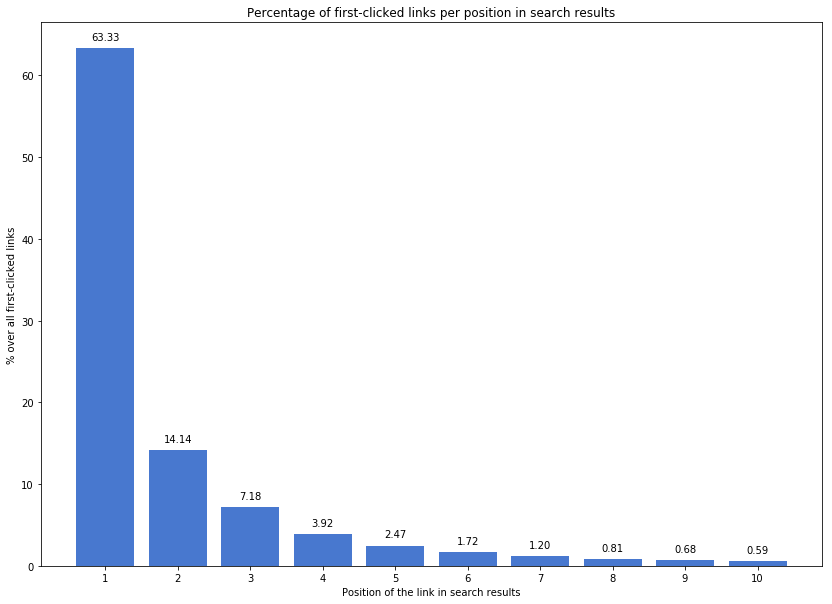

In [27]:
fig, ax = plt.subplots(figsize = (14, 10))
ax.bar(positions, pos_pct)
ax.set_title('Percentage of first-clicked links per position in search results')
ax.set_ylabel('% over all first-clicked links')
ax.set_xlabel('Position of the link in search results')
ax.set_xticks(positions)

for pos in positions:
    ax.text(pos, pos_pct[pos-1] + 1, "{:.2f}".format(pos_pct[pos-1]), horizontalalignment = 'center')

The distribution of positions appears to follow an exponential distribution.
The following plot shows the same data, divided per user group.

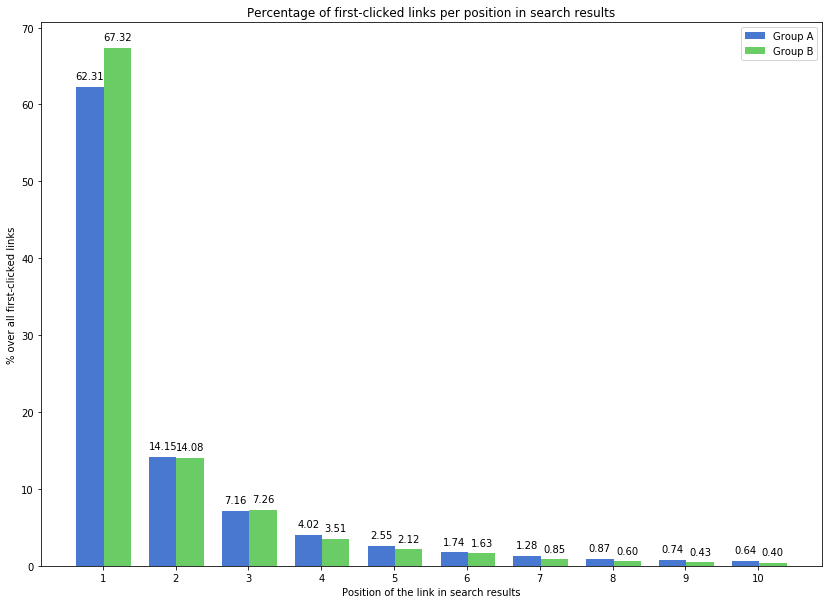

In [28]:
pg_pct = {'a': [], 'b': []}

for grp in ['a', 'b']:
    for pos in positions:
        len_select = len(first_results[(first_results.group == grp) & (first_results.result_position == pos)])
        len_all = len(first_results[first_results.group == grp])
        pg_pct[grp].append(100 * len_select / len_all)
    
fig, ax = plt.subplots(figsize = (14, 10))
ax.bar(np.array(positions) - .85 * barw, pg_pct['a'], width = .75 * barw, label = 'Group A')
ax.bar(np.array(positions) - .1 * barw, pg_pct['b'], width = .75 * barw, label = 'Group B')
ax.set_title('Percentage of first-clicked links per position in search results')
ax.set_ylabel('% over all first-clicked links')
ax.set_xlabel('Position of the link in search results')
ax.set_xticks(np.array(positions) - barw / 2)
ax.set_xticklabels(positions)
ax.legend()

for pos in positions:
    ax.text(pos - .85 * barw, pg_pct['a'][pos-1] + 1, "{:.2f}".format(pg_pct['a'][pos-1]), horizontalalignment = 'center')
    ax.text(pos - .1 * barw, pg_pct['b'][pos-1] + 1, "{:.2f}".format(pg_pct['b'][pos-1]), horizontalalignment = 'center')

Let's analyse the data day-by-day, first using all data points and then removing the outliers:
* The first plot shows the full data set and reports numerically the average position for each day.
* The second plot only shows positions $\leq 1000$.
* The third plot only shows positions $\leq 100$.
* The fourth plot again shows positions $\leq 100$, but also recomputes the average only over the positions shown.
* The fifth plot again shows the whole dataset, but splits the results per user group (A or B).

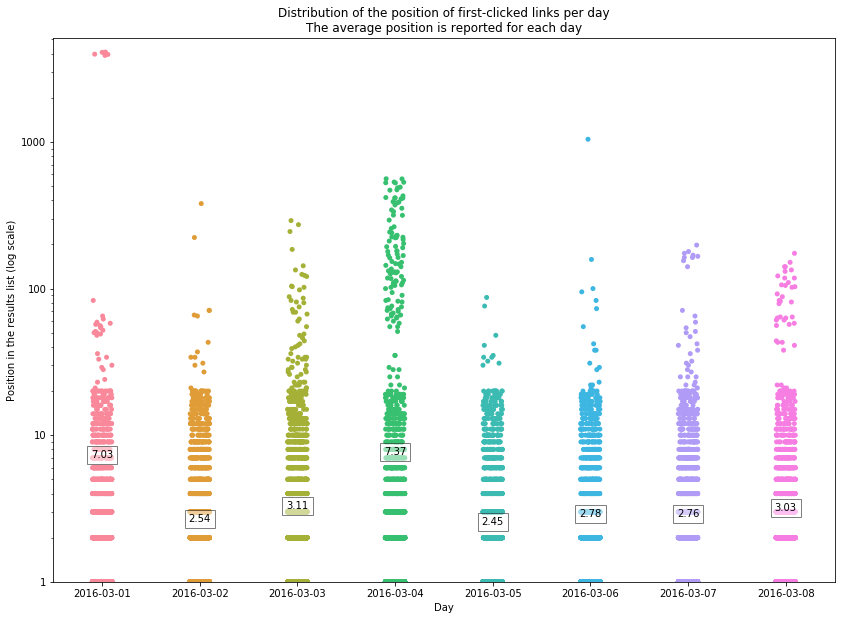

In [29]:
fig, ax = plt.subplots(figsize = (14, 10))

# Sort the x-axis by date
ordered_day = first_results.date.unique()
ordered_day.sort()

# Catplot does one scatter plot for each category (in our case category == day)
# Furthermore, it plots all the points relative to the same category on a strip,
# rather than on a straight line; in this way it minimises overlap between points
# and improves readability.
sns.catplot(x = 'date', y = 'result_position', data = first_results, ax = ax, order = ordered_day)

# Set the y scale to logarithmic, because we have many points with very low values.
# Intuitively, if the distribution is exponential (as noted above), to make the
# plot linear we want to use a logarithmic scale.
ax.set_yscale('log')

ax.set_ylim(1, first_results.result_position.max() + 1000)

ax.set_title('Distribution of the position of first-clicked links per day\nThe average position is reported for each day')
ax.set_xlabel('Day')
ax.set_ylabel('Position in the results list (log scale)')

# Avoid scientific notation on the y-axis scale
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

# Print the average position for each day
category_index = 0
for day, group in first_results.groupby('date'):
    avg = group.mean()['result_position']
    ax.text(category_index, avg, "{:.2f}".format(avg), horizontalalignment = 'center', bbox = {'facecolor': 'white', 'alpha': 0.5})
    category_index += 1

# sns.catplot automatically opens a new (empty) figure
# we close it to avoid an empty box after our plot
plt.close(2)

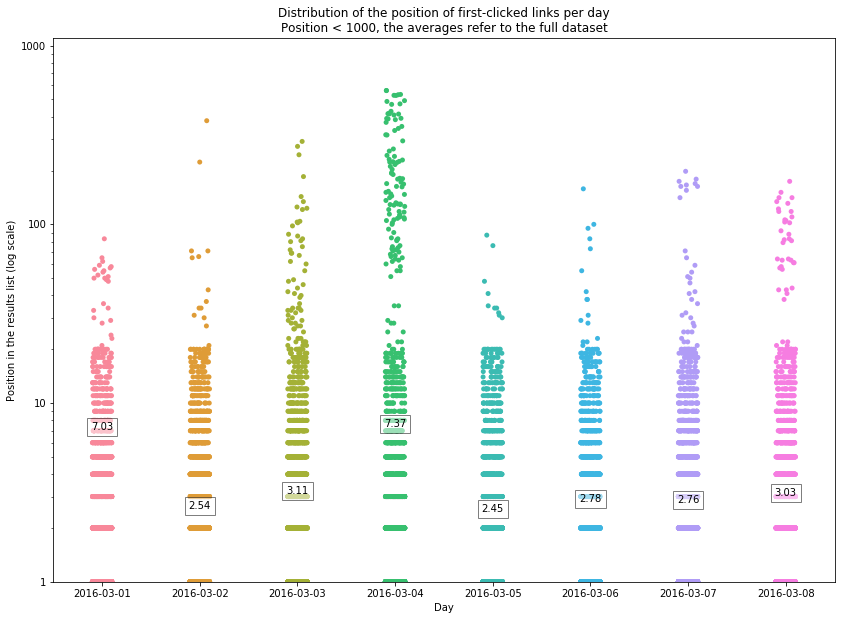

In [30]:
fig, ax = plt.subplots(figsize = (14, 10))

ordered_day = first_results.date.unique()
ordered_day.sort()

sns.catplot(x = 'date', y = 'result_position', data = first_results[first_results.result_position < 1000], ax = ax, order = ordered_day)


ax.set_yscale('log')
ax.set_ylim(1, 1100)

ax.set_title('Distribution of the position of first-clicked links per day\nPosition < 1000, the averages refer to the full dataset')
ax.set_xlabel('Day')
ax.set_ylabel('Position in the results list (log scale)')

ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

category_index = 0
for day, group in first_results.groupby('date'):
    avg = group.mean()['result_position']
    ax.text(category_index, avg, "{:.2f}".format(avg), horizontalalignment = 'center', bbox = {'facecolor': 'white', 'alpha': 0.5})
    category_index += 1

plt.close(2)

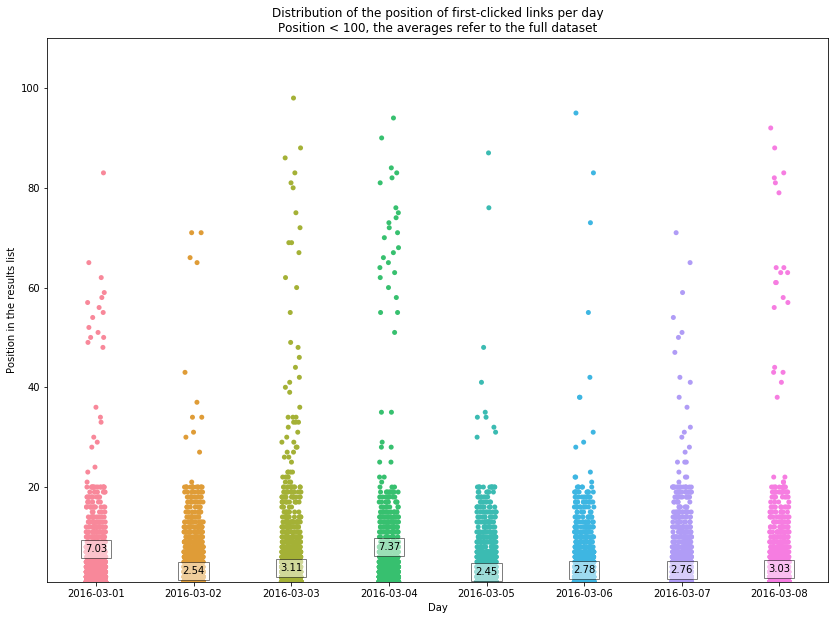

In [31]:
fig, ax = plt.subplots(figsize = (14, 10))

ordered_day = first_results.date.unique()
ordered_day.sort()

sns.catplot(x = 'date', y = 'result_position', data = first_results[first_results.result_position < 100], ax = ax, order = ordered_day)

ax.set_ylim(1, 110)

ax.set_title('Distribution of the position of first-clicked links per day\nPosition < 100, the averages refer to the full dataset')
ax.set_xlabel('Day')
ax.set_ylabel('Position in the results list')

ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

category_index = 0
for day, group in first_results.groupby('date'):
    avg = group.mean()['result_position']
    ax.text(category_index, avg, "{:.2f}".format(avg), horizontalalignment = 'center', bbox = {'facecolor': 'white', 'alpha': 0.5})
    category_index += 1

plt.close(2)

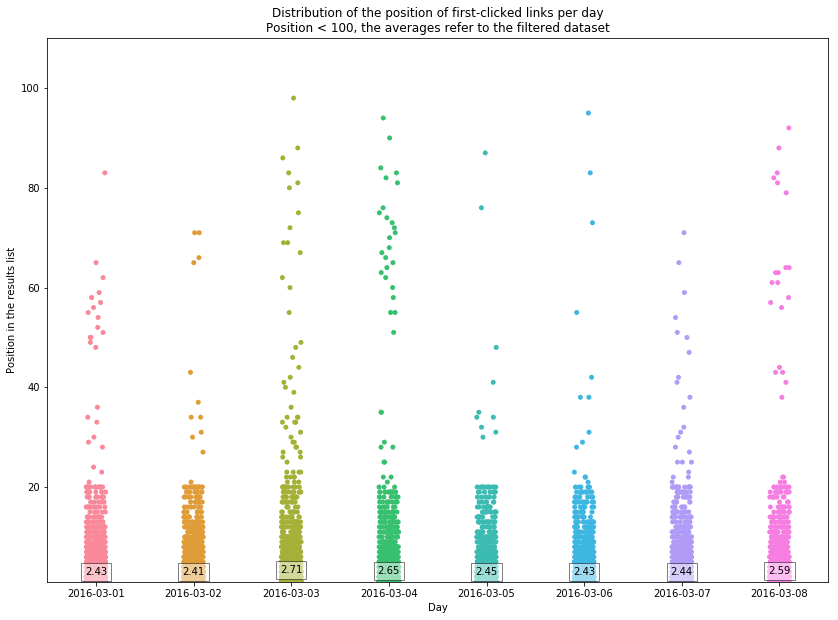

In [32]:
fig, ax = plt.subplots(figsize = (14, 10))

ordered_day = first_results.date.unique()
ordered_day.sort()

sns.catplot(x = 'date', y = 'result_position', data = first_results[first_results.result_position < 100], ax = ax, order = ordered_day)

ax.set_ylim(1, 110)

ax.set_title('Distribution of the position of first-clicked links per day\nPosition < 100, the averages refer to the filtered dataset')
ax.set_xlabel('Day')
ax.set_ylabel('Position in the results list')

ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

category_index = 0
for day, group in first_results[first_results.result_position < 100].groupby('date'):
    avg = group.mean()['result_position']
    ax.text(category_index, avg, "{:.2f}".format(avg), horizontalalignment = 'center', bbox = {'facecolor': 'white', 'alpha': 0.5})
    category_index += 1

plt.close(2)

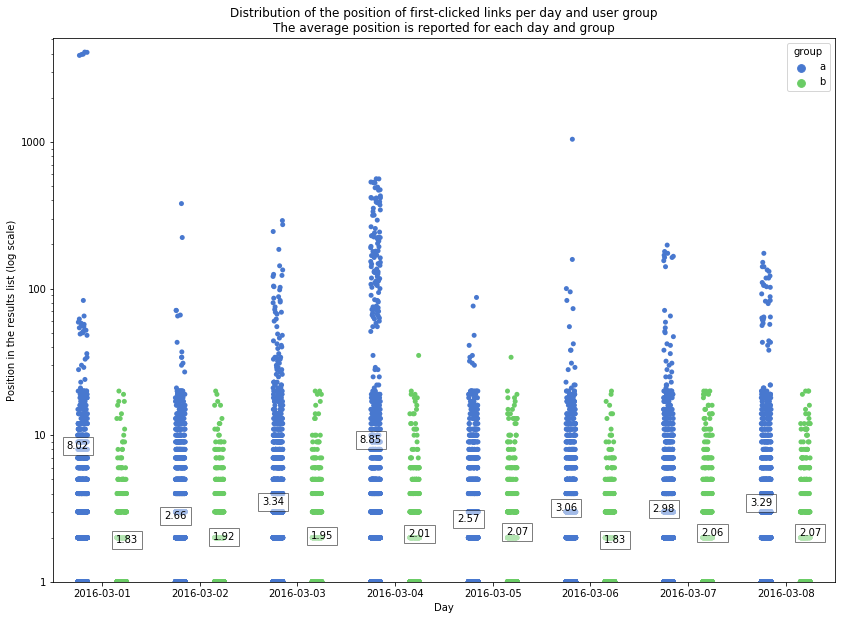

In [33]:
fig, ax = plt.subplots(figsize = (14, 10))

# Sort the x-axis by date
ordered_day = first_results.date.unique()
ordered_day.sort()

# Catplot does one scatter plot for each category (in our case category == day)
# Furthermore, it plots all the points relative to the same category on a strip,
# rather than on a straight line; in this way it minimises overlap between points
# and improves readability.
sns.catplot(x = 'date', y = 'result_position', hue = 'group', data = first_results, ax = ax, order = ordered_day, hue_order = ['a', 'b'], dodge = True)

# Set the y scale to logarithmic, because we have many points with very low values.
# Intuitively, if the distribution is exponential (as noted above), to make the
# plot linear we want to use a logarithmic scale.
ax.set_yscale('log')

ax.set_ylim(1, first_results.result_position.max() + 1000)

ax.set_title('Distribution of the position of first-clicked links per day and user group\nThe average position is reported for each day and group')
ax.set_xlabel('Day')
ax.set_ylabel('Position in the results list (log scale)')

# Avoid scientific notation on the y-axis scale
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

# Print the average position for each day
category_index = -.25
for day, group in first_results.groupby(['date', 'group']):
    avg = group.mean()['result_position']
    ax.text(category_index, avg, "{:.2f}".format(avg), horizontalalignment = 'center', bbox = {'facecolor': 'white', 'alpha': 0.5})
    category_index += .5

# sns.catplot automatically opens a new (empty) figure
# we close it to avoid an empty box after our plot
plt.close(2)

#### Answer
* An overwhelming majority of users, over 63% of them, click on the first result first.
* Overall, users in group B are more likely to click on a top result than users in group A (67.32% vs 62.31%), who instead use more results from further down the list.
* However, recall from the previous question that users of group B are less likely to click in general.
* Day-by-day the situation appears stable, except that there were two days (01 March and 04 March) with clearly different patterns:
    * On 01 March, there were a few sessions with users clicking results in position > 4000;
    * On 04 March, there were more-than-average many sessions with users clicking on results between position 80 and 1000.
    * The number of days analysed is too small to extrapolate general observations about these two days (e.g., is the day of the week relevant? are A users more likely to be outliers? etc.)

### 3. What is the daily overall zero results rate? How does it vary between the groups?

The zero-results rate is the ratio between searches which yielded zero results, and overall number of searches.

In [34]:
# Given a group, function zr_rate calculates the zero-results rate for that group
zr_rate = lambda x: len(x[(x.action == 'searchResultPage') & (x.n_results == 0)]) / len(x[x.action == 'searchResultPage'])

# We group by date and user group, and compute the zero-result rate for each group
zres = d.groupby(['date', 'group']).apply(zr_rate).to_frame('zr_rate')

In [35]:
zres

zr_rate
date       group          
2016-03-01 a      0.186775
           b      0.189399
2016-03-02 a      0.191082
           b      0.187072
2016-03-03 a      0.178539
           b      0.182344
2016-03-04 a      0.183057
           b      0.176121
2016-03-05 a      0.178240
           b      0.197517
2016-03-06 a      0.168867
           b      0.189578
2016-03-07 a      0.182377
           b      0.181242
2016-03-08 a      0.196113
           b      0.188868

In [36]:
# Create two utility dataframes, to aid plotting
# One for users of Group A, and one for those of Group B
z = zres.reset_index()
za = z[z.group == 'a']
zb = z[z.group == 'b']
zavg_a = za.zr_rate.mean()
zavg_b = zb.zr_rate.mean()

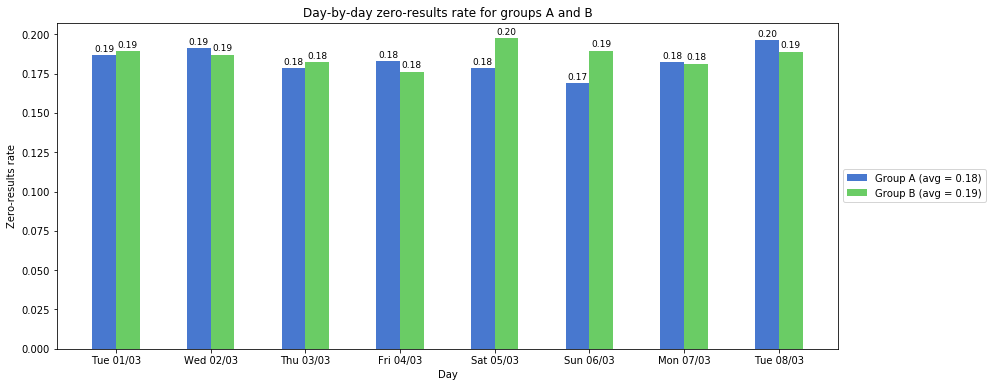

In [37]:
fig, ax = plt.subplots(figsize = (14, 6))
ax.bar(za.index, za.zr_rate, label = "Group A (avg = {:.2f})".format(zavg_a), width = barw)
ax.bar(zb.index - barw, zb.zr_rate, label = "Group B (avg = {:.2f})".format(zavg_b), width = barw)
ax.set_title('Day-by-day zero-results rate for groups A and B')
ax.set_xlabel('Day')
ax.set_ylabel('Zero-results rate')

# Place the x-axis ticks between left and right bar
ax.set_xticks(ca.index + barw/2)

# Write the date as label for each x-axis tick
xlabels = pd.to_datetime(ca.date).dt.strftime('%a %d/%m')
ax.set_xticklabels(xlabels)

# Place the legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Write the numeric value above each bar
for i, row in za.iterrows():
    ax.text(i, row.zr_rate + 0.0025, "{:.2f}".format(row.zr_rate), horizontalalignment = 'center', fontsize = 9)
for i, row in zb.iterrows():
    ax.text(i - barw, row.zr_rate + 0.0025, "{:.2f}".format(row.zr_rate), horizontalalignment = 'center', fontsize = 9)

#### Answer
* The zero-results rates are relatively high, ranging between 0.17 and 0.20, on average, depending on the day.
* From visual inspection, there appear to be no significant difference between groups nor among days of the week.

### 4. Choose a variable from the dataset and describe its relationship to session length. Visualize the relationship.

The session length is defined as "the time between the first event and the last event in a session".
I would like to prove that presenting relevant results to the user's query, makes them visit the website for longer and that, therefore, it's important to avoid giving zero results to user searches.

To prove this hypothesis, I construct a dataset containing, for each session that contains a user search:
* The user group.
* Whether or not any search was successful (results > 0)
* The session duration

In [38]:
def add_session(df, session):
    values = []
    searches = session[session.action == 'searchResultPage']
    
    # The user did not search during this session
    if(len(searches) == 0):
        return
    
    # User group
    values.append(session.iloc[0].group)
    
    # Any search result page with >0 results
    searches_with_results = searches[(searches.n_results > 0)]
    values.append(len(searches_with_results) > 0)
    
    # Session length in seconds
    session_start = session.min().timestamp
    session_end = session.max().timestamp
    values.append((session_end - session_start).total_seconds())
        
    # Append the new data row at the end of the dataframe
    df.loc[len(df), :] = values

In [39]:
%%time

# Warning: the code below takes ~ 10 minutes to run.
# To avoid recomputing the dataframe, I export it to 'res.csv'
# and read the data from there, if it exists.

res = pd.DataFrame(columns = ['group', 'any_search_results', 'session_length'])

# If the file exists...
if os.path.isfile('res.csv'):
    # Just read from file
    res = pd.read_csv('res.csv')
else:
    # Compute the relevant data for each session
    for session_id, session in d.groupby(['session_id']):
        add_session(res, session)
        
    # Force pandas to treat column session_length as a number
    res.session_length = pd.to_numeric(res.session_length)
    
    # Export to csv for next time we need it
    res.to_csv('res.csv', index = False)

CPU times: user 27.1 ms, sys: 3 µs, total: 27.1 ms
Wall time: 26.5 ms


In [40]:
# I remove outliers (points in the last percentile with respect to the session length)
res_clean = res[res.session_length < res.session_length.quantile(0.99)]

In [41]:
# First I check how many points belong to each (group, any_search_results) combination
res_grp = res_clean.groupby(['group', 'any_search_results'])
res_grp.count()

session_length
group any_search_results                
a     False                         1443
      True                         27332
b     False                         6492
      True                         32004

In [50]:
### Then I check what are the corresponding average session lengths
res_grp.mean()

session_length
group any_search_results                
a     False                    84.465003
      True                    213.808064
b     False                     4.815157
      True                     46.062023

In [52]:
# And the median session lengths
res_grp.median()

session_length
group any_search_results                
a     False                         30.0
      True                         116.0
b     False                          0.0
      True                           0.0

In [63]:
# Average session length by group only:
res_clean.groupby('group').mean()

,any_search_results,session_length
group,,
a,0.949852,207.321807
b,0.831359,39.106115


In [64]:
# Average session length by results only:
res_clean.groupby('any_search_results').mean()

,session_length
any_search_results,
False,19.299685
True,123.331047


In [ ]:
# Users og group B spend less time on the website, but can it be because
# they receive fewer results to their queries?
for grp in ['a', 'b']:
    n_sessions = len(res_clean[res_clean.group == grp])
    n_sessions_with_results = len(res_clean[(res_clean.group == grp) & (res_clean.any_search_results)])
    pct = 100 * n_sessions_with_results / n_sessions
    print("Users of group {} got some result in {:.2f}% of their sessions".format(grp, pct))

From this data it's possible to notice a few interesting things:
* Within each group, users who are receiving search results stay on the site longer than users who aren't.
* B users tend to stay on the site far less and many of them just search for something and then leave the website (session length is zero).
* B users received more zero-results page for their searches, so this can explain why they left sooner. 
* However, the median session length for B users who *did* receive results is still zero. Perhaps they are not receiving relevant search results and decide to leave?

To visualise the relationship between the presence of search results, the user group, and the session length I can use a scatter plot.
To better visualise the many thousands of data points and their distribution, I give only 10% transparency to each individual data point (`alpha = 0.1` below).

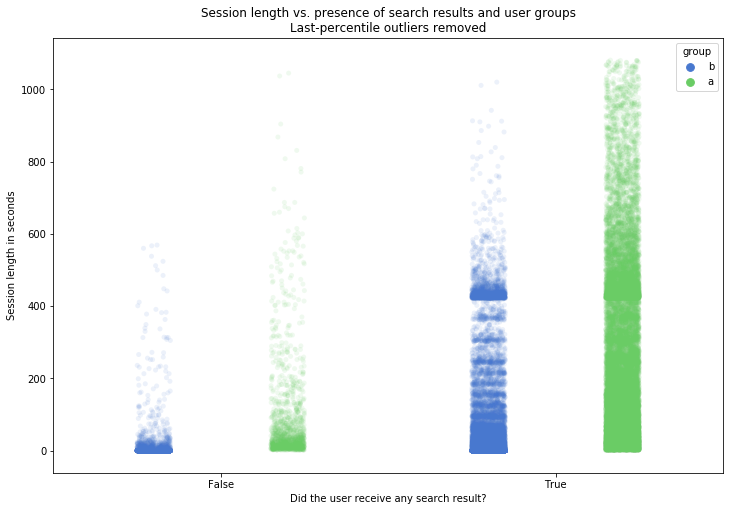

In [45]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.catplot(x = 'any_search_results', y = 'session_length', hue = 'group', alpha = 0.1, data = res_clean, dodge = True, ax = ax)
ax.set_title('Session length vs. presence of search results and user groups\nLast-percentile outliers removed')
ax.set_xlabel('Did the user receive any search result?')
ax.set_ylabel('Session length in seconds')
plt.close(2)

From the plot above we can see that, for users who received results, there are two "peaks" in session length: one nearby zero, and one (surprisingly) slightly above 400.
This is even clearer if we plot the points with 1% transparency.

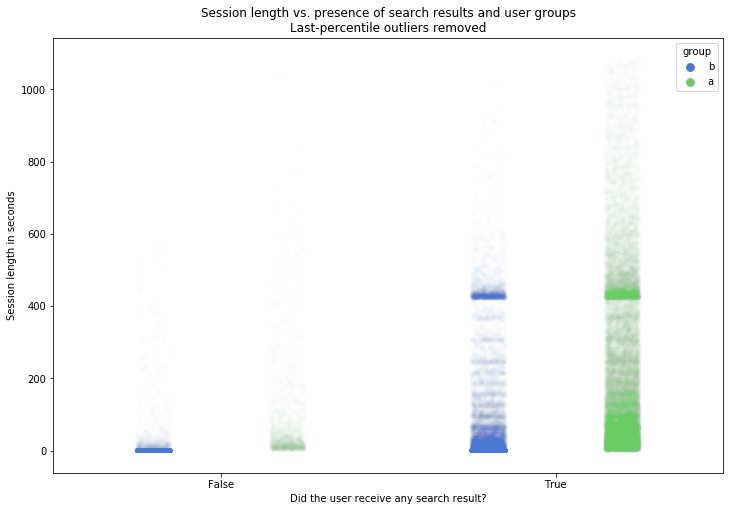

In [46]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.catplot(x = 'any_search_results', y = 'session_length', hue = 'group', alpha = 0.01, data = res_clean, dodge = True, ax = ax)
ax.set_title('Session length vs. presence of search results and user groups\nLast-percentile outliers removed')
ax.set_xlabel('Did the user receive any search result?')
ax.set_ylabel('Session length in seconds')
plt.close(2)

It is interesting, then, to visualise the distribution of the session length for users who received search results.
We can do so with a kernel density estimation plot, which shows an approximate continuous probability distribution resembling the discrete distribution of session lengths.

In [47]:
withres = res_clean[res_clean.any_search_results]

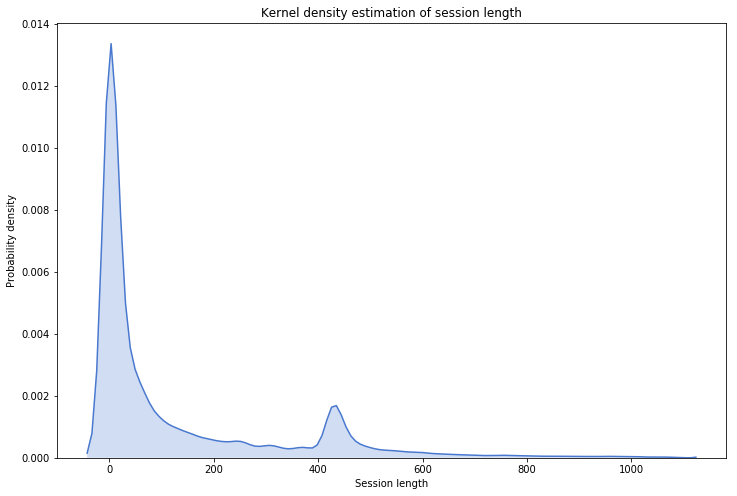

In [48]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.kdeplot(data = withres.session_length, shade = True, ax = ax, legend = False)
ax.set_title('Kernel density estimation of session length')
ax.set_xlabel('Session length')
ax.set_ylabel('Probability density');

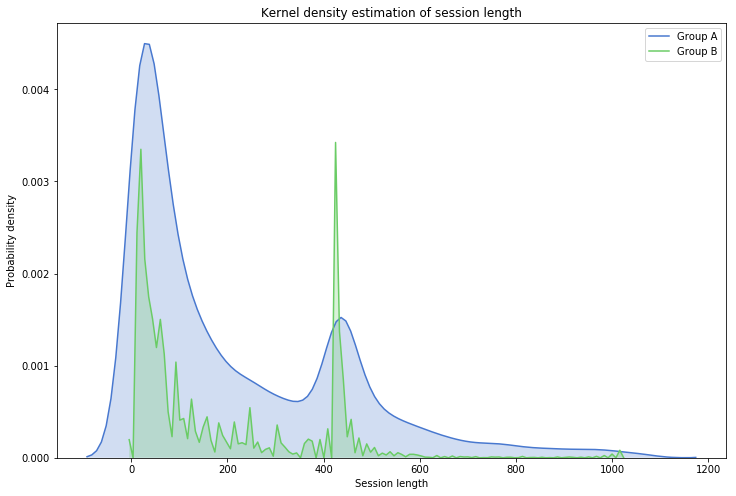

In [49]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.kdeplot(data = withres[withres.group == 'a'].session_length, shade = True, ax = ax, label = 'Group A')
sns.kdeplot(data = withres[withres.group == 'b'].session_length, shade = True, ax = ax, label = 'Group B')
ax.set_title('Kernel density estimation of session length')
ax.set_xlabel('Session length')
ax.set_ylabel('Probability density');

I can conclude that there is some "anomaly", which is more marked for B users, in the distribution of session lengths.
There is a peak at around 420-430 seconds.
Such a peak could highlight a surprising pattern in user behaviour, but might also be caused by some error in the data collection mechanism and, therefore, more investigation is needed into this issue.

#### Answer

* Data inspection shows that session length is strongly correlated to the presence of successful searches (a search with > 0 results).
* Session length also changes with the user group, A users having generally longer sessions.
* This stays true even when controlling for successful searches:
    * A users with successful searches stay longer than B users with successful searches
    * A users with no successful searches stay longer than B users with no successful searches
* The distribution of the session length is not purely exponential, but has two peaks: one around sero length, and one around 7 minutes. The reasons for this anomaly need to be investigated.